In [1]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [2]:
df = pd.read_csv('VCB.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,6/1/2018,43216,41017,43595,40866,7.57M,5.36%
1,6/4/2018,44960,42837,45187,42458,4.90M,4.04%
2,6/5/2018,44429,44429,45187,43747,4.51M,-1.18%
3,6/6/2018,44808,44050,45263,43671,2.79M,0.85%
4,6/7/2018,44505,44732,44960,44278,3.24M,-0.68%


In [3]:
# Take AR Model of lag = 3, 2 differencing for stationary
train_size = int(0.6 * len(df))
test_size = len(df) - train_size

train_data = df['Price'].iloc[:train_size]
test_data =  df['Price'].iloc[train_size:]

In [4]:
from pmdarima.arima import auto_arima
best_arima = auto_arima(train_data,trace=True)
best_arima.fit(train_data)
print(best_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12498.056, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12500.554, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12502.199, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12502.202, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12499.760, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=12506.110, Time=0.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12506.121, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12499.688, Time=1.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=12499.765, Time=1.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12504.200, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=12505.700, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12505.530, Time=0.51 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=12500.471, Time=2.18 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=12497.252, Time=0.69 sec
 ARIMA(1,1,2)(0,0,0

In [5]:
# summary of fit model
arimax_train = df[['Price','High']].iloc[:train_size]
arimax_test = df[['Price','High']].iloc[train_size:]
arimax_model = ARIMA(arimax_train['Price'],exog=arimax_train['High'],order=(2,1,2))
arimax_fitted = arimax_model.fit()
print(arimax_fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  745
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5837.075
Date:                Fri, 16 Jun 2023   AIC                          11686.150
Time:                        22:11:17   BIC                          11713.823
Sample:                             0   HQIC                         11696.817
                                - 745                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High           0.9865      0.008    129.621      0.000       0.972       1.001
ar.L1          0.9418      0.073     12.825      0.000       0.798       1.086
ar.L2         -0.0168      0.039     -0.428      0.6

C:\Users\giangle\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_arimax= arimax_fitted.predict(start=len(df)-test_size,end=len(df)-1,exog= arimax_test['High'])

# 5. Quá trình Validate
x_val= np.array(df['Price'].index).reshape(-1, 1)
y_val = np.array(df['Price'])
y_pred_val_arimax =  arimax_fitted.predict(start=0,end=train_size-1,exog=arimax_train['High'])
y_pred_val_arimax = pd.concat([y_pred_val_arimax,y_pred_arimax])

ARIMAX Validation RMSE: 754.8960537220678
ARIMAX Testing RMSE: 925.4252163626654
Validation MAPE: 0.8097148314642123
Testing MAPE: 0.8785934949939683
Validation MAE: 549.7570799672133
Testing MAE: 701.5234129993378


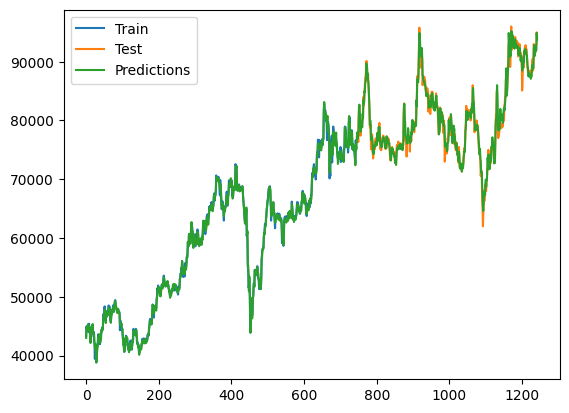

In [7]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val_arimax - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_arimax - y_test)**2))
print('ARIMAX Validation RMSE:', valid_rmse)
print('ARIMAX Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val_arimax - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred_arimax - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val_arimax - y_val))
test_mae = np.mean(np.abs(y_pred_arimax - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(df['Price'].index, y_pred_val_arimax)
# plt.plot(last_data,y_next_10_arima)
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()